# Block Model - Comparison

### For the model, see the notebook `BlockModel-Create.ipynb`

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Helper routines

In [3]:
def extract_lines(name):
    """Get data <name>."""
    inp = xr.load_dataset(name, engine='h5netcdf')
    print_attributes(inp)
    out = np.stack([
        inp.line_1[::2]+1j*inp.line_1[1::2],
        inp.line_2[::2]+1j*inp.line_2[1::2],
        inp.line_3[::2]+1j*inp.line_3[1::2],
    ]).T
    return out


def print_attributes(inp):
    """Print info from modeller."""
    for key in ['runtime', 'n_procs', 'max_ram',
                'n_cells', 'n_nodes', 'n_dof', 'extent',
                'min_vol', 'max_vol', 'machine',
                'version', 'date']:
        print(f"{key:10} : {inp.attrs[key]}")


def get_pos_neg(resp, off, min_off):
    """Separate positive and negative values, enforce min_off."""
    resp_pos = np.array([x if x > 0 else np.nan for x in resp])
    resp_neg = np.array([-x if x < 0 else np.nan for x in resp])

    resp_pos[off < min_offset] = np.nan
    resp_neg[off < min_offset] = np.nan

    return resp_pos, resp_neg

## Load info and data

### Survey info

In [4]:
ds = xr.load_dataset('block_model_and_survey.nc', engine='h5netcdf')
rec_x = ds.x[::2].data
rec_y = ds.attrs['rec_y']

### Load data, compute NRMSD

In [5]:
data = {
    'emg3d': 'emg3d',
    'custEM': 'custEM_p2',
    'PETGEM': 'petgem',
    'SimPEG': 'simpeg',
}

# Load all data
for key, value in data.items():
    print(f"\n= {key} =\n-----------")
    data[key] = extract_lines(f"results/block_{value}.nc")
    
# Compute NRMSD (%)
case_names = [
    'emg3d-SimPEG',
    'custEM-PETGEM',
    'emg3d-custEM',
    'emg3d-PETGEM',
    'custEM-SimPEG',
    'PETGEM-SimPEG',
]
nrmsd = {}
for name in case_names:
    name1, name2 = name.split('-')
    data1 = data[name1]
    data2 = data[name2]
    

def nrmsd_amplitude(data1, data2):
    return 200*abs(abs(data1) - abs(data2)) / (abs(data1) + abs(data2))

nrmsd = {
    'FV (emg3d-SimPEG)': nrmsd_amplitude(data['emg3d'], data['SimPEG']),
    'FE (custEM-PETGEM)': nrmsd_amplitude(data['custEM'], data['PETGEM']),
    'Cross-Method': (nrmsd_amplitude(data['emg3d'], data['custEM'])+
                     nrmsd_amplitude(data['emg3d'], data['PETGEM'])+
                     nrmsd_amplitude(data['SimPEG'], data['custEM'])+
                     nrmsd_amplitude(data['SimPEG'], data['PETGEM']))/4,
}


= emg3d =
-----------
runtime    : 119 s
n_procs    : 1
max_ram    : 0.400 GiB
n_cells    : (256 x 64 x 96) - 1572864
n_nodes    : N/A
n_dof      : 4813216
extent     : x = -57137.8-57137.8; y = -51967.8-51967.8; z = -35514.7-65482.0
min_vol    : 1000000.0
max_vol    : 1967671391024.1
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 15.5 GiB of memory, Ubuntu 20.04
version    : emg3d v0.16.0
date       : 2021-01-28T13:43:09.421391

= custEM =
-----------
runtime    : 312 s
n_procs    : 48
max_ram    : 281.8 GiB
n_cells    : 950476
n_nodes    : 155589
n_dof      : 12028880
extent     : x = -100000 - 100000; y = -100000 - 100000; z = -100000 - 100000
min_vol    : 125000000.0
max_vol    : 31500000000.0
machine    : PowerEdge R940 server; 144 Xeon Gold 6154 CPU @2.666 GHz; ~3 TB DDR4 RAM; Ubuntu 18.04
version    : custEM v0.99.91
date       : 2021-01-25T14:37:02.330854

= PETGEM =
-----------
runtime    : 238 s
n_procs    : 24
max_ram    : 152.8 GiB
n_cells    : 385978
n_nodes    : 65131
n_d

## Normalised Root Mean Square

In [6]:
# We plot data at offsets < min_offset
min_offset = 500

<IPython.core.display.Javascript object>


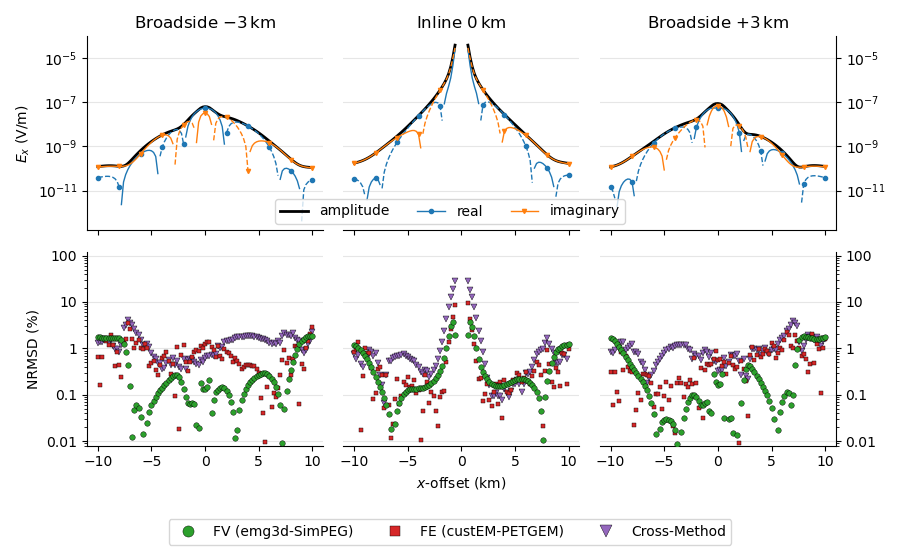

In [7]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(9, 5.5), sharey='row', sharex=True)

# # (A) Plot semi-analytical responses # #
c = ['k', 'C0', 'C1']
m = ['', 'o', 'v']
lw = [2, 1, 1]
        
# Plot over -3, 0, 3
for iy, ax in enumerate([ax1, ax2, ax3]):
    
    # Get offset
    off = np.sqrt(rec_x**2 + rec_y[iy]**2)
    
    # Title
    ax.set_title(['Broadside $-3\,$km', 'Inline $0\,$km', 'Broadside $+3\,$km'][iy])
    
    # Get positive and negative values
    for i, case in enumerate(['abs', 'real', 'imag']):
        fct = getattr(np, case)
        resp_pos, resp_neg = get_pos_neg(fct(data['emg3d'][:, iy]), off, min_offset)

        # Plot them
        popts = {'c': c[i], 'lw': lw[i], 'marker': m[i], 'ms': 3, 'markevery': 10}
        ax.plot(rec_x/1e3, resp_pos, '-', **popts, label=['amplitude', 'real', 'imaginary'][i])
        ax.plot(rec_x/1e3, resp_neg, '--', **popts)

    # Axis labeling, scaling, etc
    ax.set_yscale('log')
    ax.grid(axis='y', c='0.9')
    if iy == 0:
        ax.set_ylabel("$E_x$ (V/m)")
    elif iy == 1:
        ax.yaxis.set_ticks_position("none")
    else:
        ax.yaxis.set_ticks_position("right")
        

# # (B) Plot NRMSD # #

# Markers for scatter plots
marker = ['o', 's', 'v']
ms = [4, 3.5, 4.5]

# Plot over -3, 0, 3
for iy, ax in enumerate([ax4, ax5, ax6]):
    
    # Get offset
    off = np.sqrt(rec_x**2 + rec_y[iy]**2)
        
    # Get positive and negative values
    for i, name in enumerate(nrmsd.keys()):
        
        p_nrmsd = nrmsd[name][:, iy]
        p_nrmsd[off < min_offset] = np.nan
        ax.plot(rec_x/1e3, p_nrmsd, f"C{i+2}{marker[i]}",
                mec='k', mew=0.3,
                #mfc='none',
                ms=ms[i], zorder=10-i, label=name)
        
    # Axis labeling, scaling, etc
    ax.set_yscale('log')
    ax.set_xticks([-10, -5, 0, 5, 10])
    ax.grid(axis='y', c='0.9')
    ax.set_ylim([8e-3, 120])
    ax.set_yticks([0.01, 0.1, 1, 10, 100])
    ax.set_yticklabels(['0.01', '0.1', '1', '10', '100'])
    if iy == 0:
        ax.set_ylabel('NRMSD (%)')
    elif iy == 1:
        ax.set_xlabel('$x$-offset (km)')
        ax.yaxis.set_ticks_position("none")
    else:
        ax.yaxis.set_ticks_position("right")


# Switch off spines
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.spines['top'].set_visible(False)
for ax in [ax1, ax2, ax4, ax5]:
    ax.spines['right'].set_visible(False)
for ax in [ax2, ax3, ax5, ax6]:
    ax.spines['left'].set_visible(False)
    
plt.tight_layout(rect=[0, 0.08, 1, 1])


ax3.legend(bbox_to_anchor=(0.5, 0.58), bbox_transform=fig.transFigure, loc='lower center', ncol=3)
ax5.legend(bbox_to_anchor=(0.5, 0.01), bbox_transform=fig.transFigure,
           loc='lower center', borderaxespad=0., ncol=3, markerscale=2)

#fig.savefig(f'../manuscript/figures/results-block.pdf', bbox_inches='tight')
fig.savefig(f'../manuscript/figures/results-block.png', bbox_inches='tight', dpi=300)
fig.show()

## Actual Amplitudes

<IPython.core.display.Javascript object>


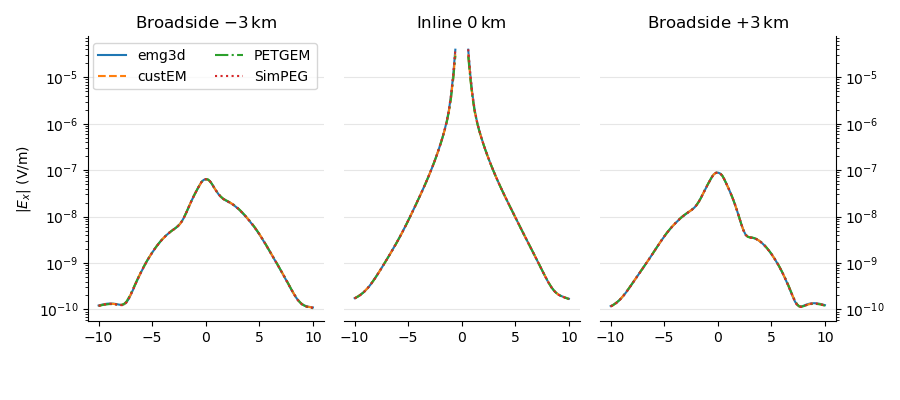

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4), sharey='row', sharex=True)

# Plot over -3, 0, 3
for iy, ax in enumerate([ax1, ax2, ax3]):
    
    # Get offset
    off = np.sqrt(rec_x**2 + rec_y[iy]**2)
    
    # Title
    ax.set_title(['Broadside $-3\,$km', 'Inline $0\,$km', 'Broadside $+3\,$km'][iy])
    ls = ['-', '--', '-.', ':']
    for i, name in enumerate(data.keys()):
        resp_pos, _ = get_pos_neg(abs(data[name][:, iy]), off, min_offset)

        # Plot them
        ax.plot(rec_x/1e3, resp_pos, f"C{i}", ls=ls[i], label=name)

    # Axis labeling, scaling, etc
    ax.set_yscale('log')
    ax.grid(axis='y', c='0.9')
    if iy == 0:
        ax.set_ylabel("$|E_x|$ (V/m)")
    elif iy == 1:
        ax.yaxis.set_ticks_position("none")
    else:
        ax.yaxis.set_ticks_position("right")

# Switch off spines
for ax in [ax1, ax2, ax3]:
    ax.spines['top'].set_visible(False)
for ax in [ax1, ax2]:
    ax.spines['right'].set_visible(False)
for ax in [ax2, ax3]:
    ax.spines['left'].set_visible(False)
    
plt.tight_layout(rect=[0, 0.1, 1, 1])


ax1.legend(ncol=2)

fig.show()

In [9]:
import scooby
scooby.Report()

--------------------------------------------------------------------------------
  Date: Thu Jan 28 20:21:58 2021 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.8.0 | packaged by conda-forge | (default, Nov 22 2019, 19:11:38)
  [GCC 7.3.0]

             numpy : 1.19.5
             scipy : 1.6.0
           IPython : 7.19.0
        matplotlib : 3.3.3
            scooby : 0.5.6

  Intel(R) Math Kernel Library Version 2020.0.4 Product Build 20200917 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------